In [1]:
def jaccard_similarity(interval_a, interval_b):
    # Lấy khoảng giao của hai đoạn
    intersection = max(0, min(interval_a[1], interval_b[1]) - max(interval_a[0], interval_b[0]))
    # Lấy khoảng hợp của hai đoạn
    union = (interval_a[1] - interval_a[0]) + (interval_b[1] - interval_b[0]) - intersection
    # Tính Jaccard Similarity
    return intersection / union if union > 0 else 0

# Độ dài của các đoạn cần so sánh (ví dụ, 10 giây)
chunk_duration = 10
video_length = 120  # giả sử video có độ dài 120 giây
num_chunks = video_length // chunk_duration

# Tính Jaccard Similarity cho mỗi đoạn và trung bình tất cả
jaccard_scores = []
for i in range(num_chunks):
    # Đoạn tương ứng trong video tóm tắt và video ground truth
    interval_a = [i * chunk_duration, (i + 1) * chunk_duration]
    interval_b = [i * chunk_duration, (i + 1) * chunk_duration]
    
    # Tính Jaccard Similarity
    score = jaccard_similarity(interval_a, interval_b)
    jaccard_scores.append(score)

# Tính Jaccard trung bình
average_jaccard_similarity = sum(jaccard_scores) / len(jaccard_scores)
print("Average Jaccard Similarity:", average_jaccard_similarity)


'/home/thiendc/projects/video_summarization'

In [ ]:
### Jarcard done

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('./data/sample_tv360/video_chunk/video_chunk_10_scenes.csv')
gt = pd.read_csv('./data/sample_tv360/video_chunk/video_chunk_10_scenes_gt.csv')

merged = pd.merge(data, gt, on = 'Video Segment')

merged['intersection'] = np.maximum(0, np.minimum(merged['data_end'], merged['gt_end']) - np.maximum(merged['data_start'], merged['gt_start']))
merged['full'] = (merged['data_end'] -merged['data_start']) +(- merged['gt_start'] + merged['gt_end']) - merged['intersection']
merged['jarcard'] = merged['intersection']/merged['full']

import numpy
numpy.average(merged['jarcard'])

0.283064935064935

In [20]:
### Embedding comparision based ViT, based CLIP, based ResNet
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-728va4yu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-728va4yu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=9ce7b982f4dae394f446229359f2da16177d9363551e80fa9466583d2a6c6fe3
  Stored in directory: /tmp/pip-ephem-wheel-cache-0d0dxbwk/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [42]:
# np.linspace(0, frame_count - 1, num_frames, dtype=int)
# Kiểm tra số lượng frame trong video đầu ra
output_path = './data/sample_tv360/gt/chunk_3_gt.mp4'  # Ví dụ với video đầu ra đầu tiên
cap = cv2.VideoCapture(output_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"Số lượng frame trong video đầu ra: {frame_count}")  # Kiểm tra phải bằng 810


Số lượng frame trong video đầu ra: 810


In [49]:
import cv2
import numpy as np
import torch
from torchvision import models, transforms
from transformers import ViTFeatureExtractor, ViTModel
import clip
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Khởi tạo mô hình ResNet50
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

inception_model = models.inception_v3(pretrained=True)
inception_model.eval()

# Khởi tạo mô hình CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")  # hoặc 'cuda' nếu có GPU

# Khởi tạo mô hình ViT
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to('cuda')
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

preprocess = transforms.Compose([
    transforms.Resize(299),  # Inception v3 yêu cầu kích thước đầu vào 299x299
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_inception_embedding(frame):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = preprocess(frame_pil).unsqueeze(0)  # Chuyển tensor sang GPU nếu có
    with torch.no_grad():
        embedding = inception_model(input_tensor)
    return embedding.squeeze().cpu().numpy()

# Hàm trích xuất embedding cho một frame với ResNet
def get_resnet_embedding(frame):
    
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = preprocess(frame_pil).unsqueeze(0)
    with torch.no_grad():
        embedding = resnet_model(input_tensor)
    return embedding.squeeze().numpy()

# Hàm trích xuất embedding cho một frame với CLIP
def get_clip_embedding(frame):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = clip_preprocess(frame_pil).unsqueeze(0).to('cuda')
    with torch.no_grad():
        embedding = clip_model.encode_image(input_tensor).cpu().numpy().squeeze()
    return embedding

# Hàm trích xuất embedding cho một frame với ViT
def get_vit_embedding(frame):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = vit_feature_extractor(images=frame_pil, return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.pooler_output.squeeze().cpu().numpy()

# Hàm để tính trung bình embedding cho toàn bộ video
def get_video_embedding(video_path, model_type='resnet', method = 'concat'):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    num_frames = int(frame_count/cap.get(cv2.CAP_PROP_FPS))
    
    frame_indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)

    embeddings = []
    for idx in tqdm(frame_indices, desc = "Extracting frame embeddings"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        if model_type == 'resnet':
            embedding = get_resnet_embedding(frame)
        elif model_type == 'clip':
            embedding = get_clip_embedding(frame)
        elif model_type == 'vit':
            embedding = get_vit_embedding(frame)
        elif model_type == 'inception':
            embedding = get_inception_embedding(frame)
        else:
            raise ValueError("Model type không hợp lệ. Chọn 'resnet', 'clip', hoặc 'vit'.")

        embeddings.append(embedding)

    cap.release()
    
    if len(embeddings) != num_frames:
        print(f"Warning: Video {video_path} không có đủ {num_frames} frame, chỉ có {len(embeddings)} frame.")
        return np.nan
    
    # Tính trung bình embedding để tạo thành vector duy nhất
    if method == 'mean':
        video_embedding = np.mean(embeddings, axis=0)
    elif method == 'concat':
        video_embedding = np.concatenate(embeddings)
        
    if np.isnan(video_embedding).any():
        print(f"Embedding contains NaN for video: {video_path}")
        return np.nan

    return video_embedding

# Tính toán Cosine Similarity giữa hai video
def compare_videos(video1_path, video2_path, model_type='resnet'):
    embedding1 = get_video_embedding(video1_path, model_type)
    embedding2 = get_video_embedding(video2_path, model_type)
    
    # Kiểm tra nếu embedding chứa NaN
    if np.isnan(embedding1).any() or np.isnan(embedding2).any():
        print(f"Embedding contains NaN for videos: {video1_path}, {video2_path}")
        return np.nan  # Hoặc giá trị khác phù hợp

    cosine_sim = cosine_similarity([embedding1], [embedding2])[0][0]
    # print(f"Cosine Similarity giữa hai video sử dụng {model_type.upper()}:", cosine_sim)
    return cosine_sim

# import os
# from tqdm import tqdm
# root_gt = "./data/sample_tv360/gt"
# root_data = "./data/sample_tv360/do_merge"

# sorted_gt = sorted(os.listdir('./data/sample_tv360/gt'), key = lambda x : int(x.split("_")[1]))
# sorted_data = sorted(os.listdir("./data/sample_tv360/do_merge"), key = lambda x: int(x.split("_")[-1].split(".")[0]))

# resnet_cs = []
# for i, j in tqdm(zip(sorted_gt, sorted_data)):
#     resnet = compare_videos(f"{root_data}/{i}", f"{root_gt}/{j}", model_type='resnet')
#     resnet_cs.append(resnet)

/home/thiendc/projects/.thienenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thiendc/projects/.thienenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/thiendc/projects/.thienenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also 

In [50]:
import os
from tqdm import tqdm
root_gt = "./data/sample_tv360/gt"
root_data = "./data/sample_tv360/do_merge"

sorted_gt = sorted(os.listdir('./data/sample_tv360/gt'), key = lambda x : int(x.split("_")[1]))
sorted_data = sorted(os.listdir("./data/sample_tv360/do_merge"), key = lambda x: int(x.split("_")[-1].split(".")[0]))

In [51]:
resnet_cs, inception_cs, vit_cs, clip_cs = [], [], [], []
for i, j in tqdm(zip(sorted_gt, sorted_data)):
    print("Đây là ", i, "và", j)
    resnet = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='resnet')
    resnet_cs.append(resnet)
    inception = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='inception')
    inception_cs.append(inception)
    vit = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='vit')
    vit_cs.append(vit)
    clip = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='clip')
    clip_cs.append(clip)

print("Đây là kết quả cosine dựa trên độ đo RESNET", np.average(resnet_cs))
print("Đây là kết quả cosine dựa trên độ đo Inception", np.average(inception_cs))
print("Đây là kết quả cosine dựa trên độ đo ViT", np.average(vit_cs))
print("Đây là kết quả cosine dựa trên độ đo CLIP", np.average(clip_cs))


0it [00:00, ?it/s]

Đây là  chunk_1_gt.mp4 và merged_video_processed_1.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:02<00:00, 11.12it/s]
1it [00:21, 21.58s/it]

Đây là  chunk_2_gt.mp4 và merged_video_processed_2.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:02<00:00, 12.66it/s]
2it [00:39, 19.63s/it]

Đây là  chunk_3_gt.mp4 và merged_video_processed_3.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 15.23it/s]
3it [00:56, 18.39s/it]

Đây là  chunk_4_gt.mp4 và merged_video_processed_4.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:03<00:00,  7.74it/s]
4it [01:21, 20.82s/it]

Đây là  chunk_5_gt.mp4 và merged_video_processed_5.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 13.79it/s]
5it [01:38, 19.65s/it]

Đây là  chunk_6_gt.mp4 và merged_video_processed_6.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 18.90it/s]
6it [01:53, 18.08s/it]

Đây là  chunk_7_gt.mp4 và merged_video_processed_7.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 19.17it/s]
7it [02:09, 17.12s/it]

Đây là  chunk_8_gt.mp4 và merged_video_processed_8.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 17.87it/s]
8it [02:24, 16.57s/it]

Đây là  chunk_9_gt.mp4 và merged_video_processed_9.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 13.97it/s]
9it [02:41, 16.80s/it]

Đây là  chunk_10_gt.mp4 và merged_video_processed_10.mp4


Extracting frame embeddings: 100%|██████████| 27/27 [00:03<00:00,  8.80it/s]
10it [03:04, 18.43s/it]

Đây là kết quả cosine dựa trên độ đo RESNET 0.6147928
Đây là kết quả cosine dựa trên độ đo Inception 0.40568596
Đây là kết quả cosine dựa trên độ đo ViT 0.70448124
Đây là kết quả cosine dựa trên độ đo CLIP 0.7094341216551523


In [ ]:
# F1-score

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Hàm tính Precision, Recall, F1-Score giữa hai danh sách các đoạn video
def calculate_f1_score(video1_embeddings, video2_embeddings, threshold=0.8):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Tính Cosine Similarity giữa từng đoạn của video tóm tắt và video ground truth
    for i, emb1 in enumerate(video1_embeddings):
        max_sim = 0
        for emb2 in video2_embeddings:
            cos_sim = cosine_similarity([emb1], [emb2])[0][0]
            if cos_sim > max_sim:
                max_sim = cos_sim

        # Đoạn có cosine similarity lớn hơn ngưỡng được coi là tương đồng
        if max_sim >= threshold:
            true_positives += 1
        else:
            false_positives += 1

    # False Negatives: Đoạn trong video ground truth mà không có đoạn tương ứng trong video tóm tắt
    for emb2 in video2_embeddings:
        max_sim = 0
        for emb1 in video1_embeddings:
            cos_sim = cosine_similarity([emb2], [emb1])[0][0]
            if cos_sim > max_sim:
                max_sim = cos_sim

        if max_sim < threshold:
            false_negatives += 1

    # Tính Precision, Recall và F1-Score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [57]:
f1_scores_dict = {}
embeddings = ['resnet', 'inception', 'vit', 'clip']

# Các giá trị threshold
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]
for embedding  in tqdm(embeddings):
    video1, video2 = [], []
    for i, j in tqdm(zip(sorted_gt, sorted_data)):
        video1_embedding, video2_embedding = get_video_embedding(f"{root_gt}/{i}", model_type = embedding ), get_video_embedding(f"{root_data}/{j}", model_type = embedding )
        video1.append(video1_embedding)
        video2.append(video2_embedding)

    f1_scores = []
    for threshold in tqdm(thresholds):
        _, _, f1_score = calculate_f1_score(video1, video2, threshold= threshold)
        f1_scores.append(f1_score)
    
    f1_scores_dict[embedding] = f1_scores
    

  0%|          | 0/4 [00:00<?, ?it/s]














Extracting frame embeddings: 100%|██████████| 27/27 [00:02<00:00, 12.84it/s]




















Extracting frame embeddings: 100%|██████████| 27/27 [00:03<00:00,  7.40it/s]














Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 13.54it/s]




















Extracting frame embeddings: 100%|██████████| 27/27 [00:03<00:00,  8.10it/s]














Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 13.77it/s]





















Extracting frame embeddings: 100%|██████████| 27/27 [00:03<00:00,  8.75it/s]














Extracting frame embeddings: 100%|██████████| 27/27 [00:01<00:00, 13.60it/s]






















Extracting frame embeddings: 100%|██████████| 27/27 [00:04<00:00,  5.53it/s]














Extracting frame embeddings: 100%|██████████| 27/27 [00:02<00:00, 13.14it/s]





















Extracting frame embeddings: 100%|██████████| 27/27 [00:03<00:00,  8.06it/s]














Extr

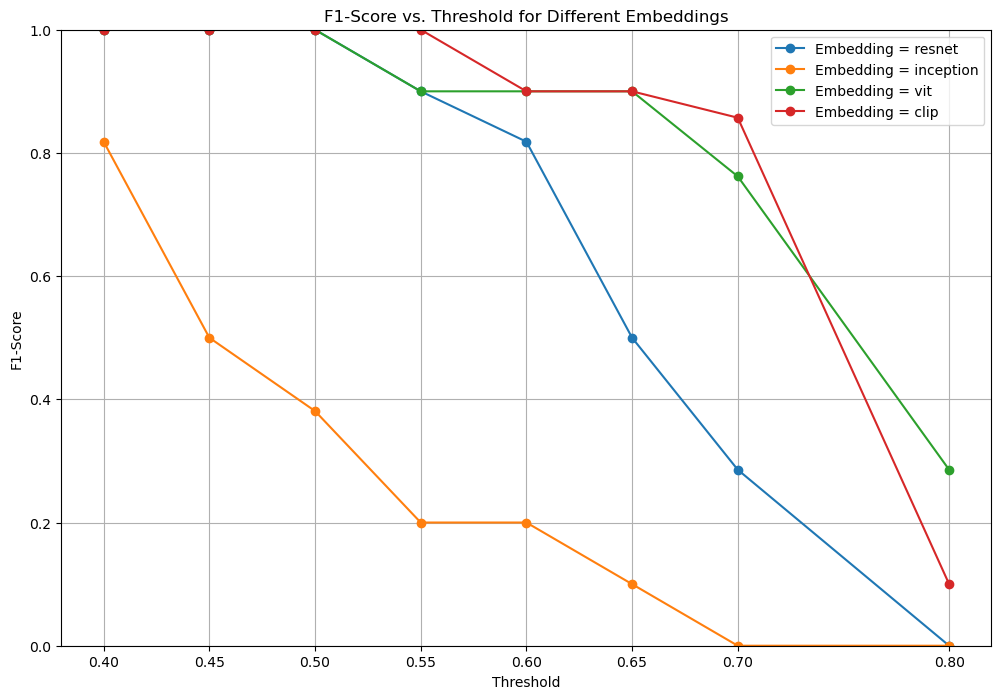

In [58]:
import matplotlib.pyplot as plt

# Dữ liệu cần vẽ
plt.figure(figsize=(12, 8))

for embedding in embeddings:
    plt.plot(thresholds, f1_scores_dict[embedding], marker='o', linestyle='-', label=f'Embedding = {embedding}')

plt.title('F1-Score vs. Threshold for Different Embeddings')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(thresholds)
plt.legend()
plt.show()
